<a href="https://colab.research.google.com/github/Anonymoouuus/ER2025/blob/main/Model_ER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Implementation of the Unified Representation framework (TSS -> FTSS transformation)
from datetime import datetime, timedelta

# Helper to parse datetime strings
def parse_datetime(dt_str):
    return datetime.strptime(dt_str, "%Y-%m-%d %H:%M")



# Transformation Process



## Temporal Information Completion

In [2]:
# Define default values for each data type (in minutes)
EPSILONS = {
    'medical': 20,
    'mobility': 5,
    'communication': 5,
    'weather': 1440,
    'student' : 15
}

def parse_timestamp(ts):
    return datetime.strptime(ts, '%Y-%m-%d %H:%M') if isinstance(ts, str) else ts

def transform_to_ftss(data, data_type):
    epsilon = EPSILONS[data_type]
    transformed = []

    for i, (ts, duration, semantics) in enumerate(data):
        # Parse timestamp if it's a string
        if ts is not None: # valid timestamp
            ts = parse_timestamp(ts)

        # Rule 1: timestamp known, duration not known
        if ts is not None and duration is None:
            if i + 1 < len(data) and data[i + 1][0] is not None:
                next_ts = parse_timestamp(data[i + 1][0])
                duration_minutes = min((next_ts - ts).total_seconds() / 60, epsilon)
            else:
                duration_minutes = epsilon

        # Rule 2: timestamp not known, duration known
        elif ts is None and duration is not None:
            duration_minutes = duration
            if i == 0:
                ts = datetime(2025, 1, 1, 0, 0)  # arbitrary start point
            else:
                prev_ts = transformed[i - 1][0]
                prev_duration = transformed[i - 1][1]
                ts = prev_ts + timedelta(minutes=prev_duration) # timedelta is used for calculating differences in dates and also can be used for date manipulations

        # Rule 3: neither timestamp nor duration known
        elif ts is None and duration is None:
            ts = datetime(2025, 1, 1, 0, 0) + timedelta(minutes=i)  # t_i = i
            duration_minutes = epsilon  # min duration
        else:
            duration_minutes = duration

        transformed.append((ts, duration_minutes, semantics))

    return transformed


In [3]:
# Example for Temporal Information Completion
activity_data = [
    ('2025-04-01 07:45', 45, {'Car commute'}),
    ('2025-04-01 08:45', 15, {'Café walk'}),
    ('2025-04-01 09:00', None, {'Text reply'}),
    ('2025-04-01 09:05', 175, {'Office work'}),
    ('2025-04-01 12:00', 45, {'Lunch walk'}),
    ('2025-04-01 13:15', 45, {'Train commute'}),
    ('2025-04-01 14:05', None, {'Call confirm'}),
    ('2025-04-01 14:15', 195, {'Site inspection walk'}),
    ('2025-04-01 17:30', 30, {'Taxi ride'})

]

tss_complete = transform_to_ftss(activity_data, data_type='mobility')

for event in tss_complete:
    print(f"Timestamp: {event[0]}, Duration: {event[1]} minutes, Activity: {event[2]}")


Timestamp: 2025-04-01 07:45:00, Duration: 45 minutes, Activity: {'Car commute'}
Timestamp: 2025-04-01 08:45:00, Duration: 15 minutes, Activity: {'Café walk'}
Timestamp: 2025-04-01 09:00:00, Duration: 5.0 minutes, Activity: {'Text reply'}
Timestamp: 2025-04-01 09:05:00, Duration: 175 minutes, Activity: {'Office work'}
Timestamp: 2025-04-01 12:00:00, Duration: 45 minutes, Activity: {'Lunch walk'}
Timestamp: 2025-04-01 13:15:00, Duration: 45 minutes, Activity: {'Train commute'}
Timestamp: 2025-04-01 14:05:00, Duration: 5 minutes, Activity: {'Call confirm'}
Timestamp: 2025-04-01 14:15:00, Duration: 195 minutes, Activity: {'Site inspection walk'}
Timestamp: 2025-04-01 17:30:00, Duration: 30 minutes, Activity: {'Taxi ride'}


________________________________________________________________________________________________________

## Transformation of TSS into FTSS : algorithm
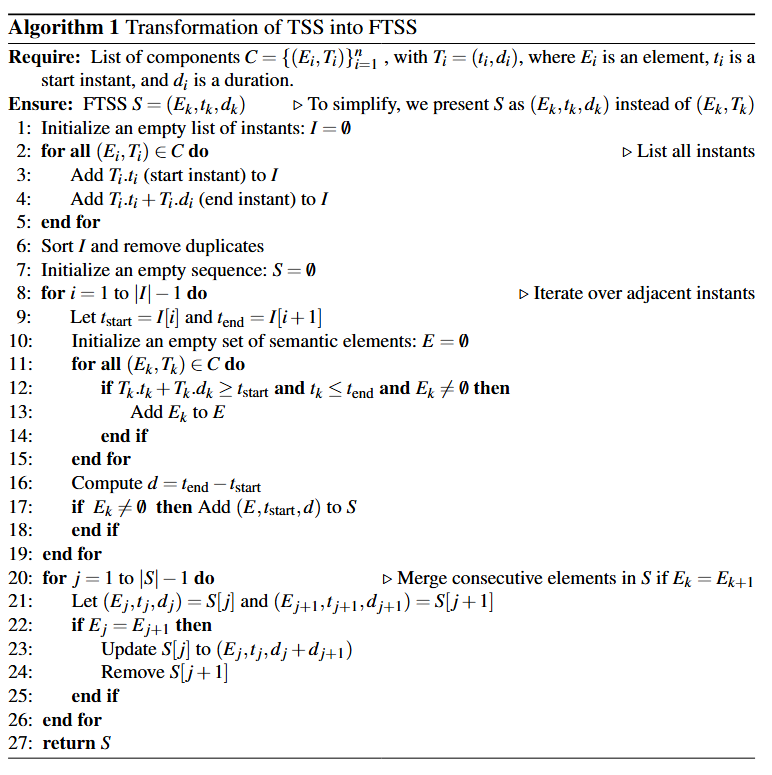

In [4]:

def tss_to_ftss(tss_list):
    """
    Transforms multiple Temporal Semantic Sequences (TSS) with complete timestamps and durations from different
    sources (e.g., weather, mobility, communication) into a Fully-Temporal Semantic Sequence (FTSS) using slicing and flattening.

    Parameters:
        tss_list (list of list): A List lists where each element is a TSS (i.e., a list of (start_time, duration, semantic_set))

    Returns:
        list: A single FTSS as a list of tuples (semantic_set, start_time, duration)
    """
    # STEP 1: Initialize the list of all significant time instants (starts and ends)
    instants = set()
    for tss in tss_list:
      for (start_time, duration_minutes, semantic_set) in tss:
          # Compute the end time by adding duration to start
          end_time = start_time + timedelta(minutes=duration_minutes)

          # Add start and end to the list of instants
          instants.add(start_time)
          instants.add(end_time)

    # STEP 2: Sort the instants and remove duplicates
    sorted_instants = sorted(instants)

    # STEP 3: Initialize the result FTSS sequence
    ftss = []

    # STEP 4: Iterate over adjacent instants (tstart, tend)
    for i in range(len(sorted_instants) - 1):
        tstart = sorted_instants[i]
        tend = sorted_instants[i + 1]
        interval_duration = (tend - tstart).total_seconds() / 60  # duration in minutes

        # STEP 5: Determine the semantic elements that are active in this interval
        active_semantics = set()

        for tss in tss_list:
          for (element_start, duration, semantics) in tss:
              element_end = element_start + timedelta(minutes=duration)

              # Check for temporal overlap with the current interval
              if element_end > tstart and element_start < tend and semantics:
                  active_semantics.update(semantics)

        # STEP 6: Add the slice to FTSS if the semantic set is not empty
        if active_semantics:
            ftss.append((active_semantics, tstart, interval_duration))

    # STEP 7: Merge adjacent slices with same semantic elements
    i = 0
    while i < len(ftss) - 1:
        current_semantics, current_time, current_duration = ftss[i]
        next_semantics, next_time, next_duration = ftss[i + 1]

        # Merge if semantic sets are equal and intervals are adjacent
        if current_semantics == next_semantics and \
           current_time + timedelta(minutes=current_duration) == next_time:
            # Merge durations
            merged_duration = current_duration + next_duration
            # Update current slice
            ftss[i] = (current_semantics, current_time, merged_duration)
            # Remove the next one
            ftss.pop(i + 1)
        else:
            i += 1

    return ftss


# Summarizing Example
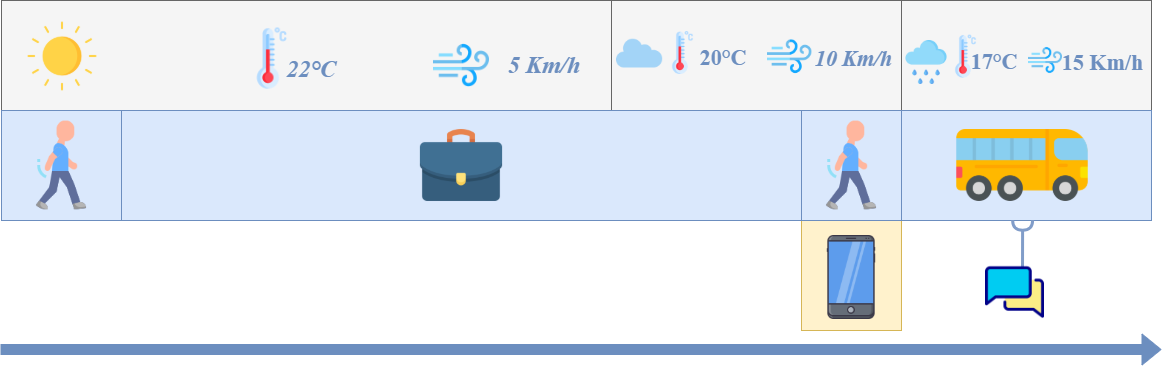

In [12]:
# The summarizing Example presented in the paper
weather_data_example = [
    ('2025-04-01 07:45', 215, {'Temp: 22°C', 'Sunny', 'Wind: 5 km/h'}),
    ('2025-04-01 11:20', 45, {'Temp: 20°C', 'Cloudy', 'Wind: 10 km/h'}),
    ('2025-04-01 12:05', 35, {'Rain', 'Temp: 17°C', 'Rainy', 'Wind: 15 km/h'})
]


mobility_data_example = [
    ('2025-04-01 07:45', 15, {21}),
    ('2025-04-01 08:00', 240, {111}),
    ('2025-04-01 12:00', 5, {21}),
    ('2025-04-01 12:05', 35, {31})
]

communication_data_example = [
    ('2025-04-01 12:00', 5, {'Call'}),
    ('2025-04-01 12:20', None, {'Text'})
]

In [10]:
# HETUS code mapping for mobility activities
HETUS_ACTIVITY_CODES = {
    21: 'Travelling on foot',
    111: 'Working time',
    31: 'Travelling by public transport'
}

def decrypt_activity(activity_set, data_type='mobility'):
    if data_type == 'mobility':
        return {HETUS_ACTIVITY_CODES.get(code, f"{code}") for code in activity_set}
    return activity_set


In [13]:
# Temporal Information Completion

weather_tss_complete = transform_to_ftss(weather_data_example, data_type='weather')
mobility_tss_complete = transform_to_ftss(mobility_data_example, data_type='mobility')
communication_tss_complete = transform_to_ftss(communication_data_example, data_type='communication')

print("Weather:")
for ts, duration, semantics in weather_tss_complete:
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Activity: {semantics}")
print('-----------------------------------------------')

print("Mobility:")
for ts, duration, activity_codes in mobility_tss_complete:
    readable_activities = decrypt_activity(activity_codes, data_type='mobility')
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Activity: {readable_activities}")
print('-----------------------------------------------')

print("Communication:")
for ts, duration, semantics in communication_tss_complete:
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Activity: {semantics}")

Weather:
Timestamp: 2025-04-01 07:45:00, Duration: 215 minutes, Activity: {'Sunny', 'Temp: 22°C', 'Wind: 5 km/h'}
Timestamp: 2025-04-01 11:20:00, Duration: 45 minutes, Activity: {'Cloudy', 'Temp: 20°C', 'Wind: 10 km/h'}
Timestamp: 2025-04-01 12:05:00, Duration: 35 minutes, Activity: {'Temp: 17°C', 'Wind: 15 km/h', 'Rainy', 'Rain'}
-----------------------------------------------
Mobility:
Timestamp: 2025-04-01 07:45:00, Duration: 15 minutes, Activity: {'Travelling on foot'}
Timestamp: 2025-04-01 08:00:00, Duration: 240 minutes, Activity: {'Working time'}
Timestamp: 2025-04-01 12:00:00, Duration: 5 minutes, Activity: {'Travelling on foot'}
Timestamp: 2025-04-01 12:05:00, Duration: 35 minutes, Activity: {'Travelling by public transport'}
-----------------------------------------------
Communication:
Timestamp: 2025-04-01 12:00:00, Duration: 5 minutes, Activity: {'Call'}
Timestamp: 2025-04-01 12:20:00, Duration: 5 minutes, Activity: {'Text'}


In [14]:
# Convert to FTSS
ftss_result = tss_to_ftss([weather_tss_complete, mobility_tss_complete, communication_tss_complete])

# Display result
print('______________________________________________ Final FTSS_________________________________________________')
for (semantics, start, duration) in ftss_result:
    print(f"Start: {start}, Duration: {duration} min, Semantics: {semantics}")

______________________________________________ Final FTSS_________________________________________________
Start: 2025-04-01 07:45:00, Duration: 15.0 min, Semantics: {'Sunny', 21, 'Temp: 22°C', 'Wind: 5 km/h'}
Start: 2025-04-01 08:00:00, Duration: 200.0 min, Semantics: {'Sunny', 'Temp: 22°C', 'Wind: 5 km/h', 111}
Start: 2025-04-01 11:20:00, Duration: 40.0 min, Semantics: {'Cloudy', 111, 'Temp: 20°C', 'Wind: 10 km/h'}
Start: 2025-04-01 12:00:00, Duration: 5.0 min, Semantics: {'Call', 'Cloudy', 21, 'Temp: 20°C', 'Wind: 10 km/h'}
Start: 2025-04-01 12:05:00, Duration: 15.0 min, Semantics: {'Temp: 17°C', 'Wind: 15 km/h', 'Rain', 'Rainy', 31}
Start: 2025-04-01 12:20:00, Duration: 5.0 min, Semantics: {'Temp: 17°C', 'Wind: 15 km/h', 'Rain', 'Text', 'Rainy', 31}
Start: 2025-04-01 12:25:00, Duration: 15.0 min, Semantics: {'Temp: 17°C', 'Wind: 15 km/h', 'Rain', 'Rainy', 31}


## Other Examples

In [15]:
#______________________________________________________________ Other Examples _________________________________________________________________________________________________________________

activity_data = [
    ('2025-04-01 07:45', 45, {'Car commute'}),
    ('2025-04-01 08:45', 15, {'Café walk'}),
    ('2025-04-01 09:00', None, {'Text reply'}),
    ('2025-04-01 09:05', 175, {'Office work'}),
    ('2025-04-01 12:00', 45, {'Lunch walk'}),
    ('2025-04-01 13:15', 45, {'Train commute'}),
    ('2025-04-01 14:05', None, {'Call confirm'}),
    ('2025-04-01 14:15', 195, {'Site inspection walk'}),
    ('2025-04-01 17:30', 30, {'Taxi ride'})
]


weather_data = [
    ('2025-04-01 06:00', 90, {'Rain: Heavy', 'Temp: 6°C', 'Wind: 3 km/h'}),
    ('2025-04-01 07:30', 90, {'Rain: Light', 'Temp: 8°C', 'Wind: 5 km/h'}),
    ('2025-04-01 09:00', 120, {'Rain: Moderate', 'Temp: 10°C', 'Wind: 7 km/h'}),
    ('2025-04-01 11:00', 90, {'Rain: Drizzle', 'Temp: 12°C', 'Wind: 6 km/h'}),
    ('2025-04-01 12:30', 90, {'Rain: None', 'Temp: 15°C', 'Wind: 4 km/h'}),
    ('2025-04-01 14:00', 60, {'Rain: Scattered', 'Temp: 14°C', 'Wind: 12 km/h'})
]


In [16]:
# Temporal Information Completion

weather_data_complete = transform_to_ftss(weather_data, data_type='weather')
activity_data_complete = transform_to_ftss(activity_data, data_type='mobility')

print("Weather:")
for ts, duration, semantics in weather_data_complete:
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Activity: {semantics}")
print('-----------------------------------------------')

print("Daily Activity:")
for ts, duration, activity_codes in activity_data_complete:
    readable_activities = decrypt_activity(activity_codes, data_type='mobility')
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Activity: {readable_activities}")


Weather:
Timestamp: 2025-04-01 06:00:00, Duration: 90 minutes, Activity: {'Rain: Heavy', 'Wind: 3 km/h', 'Temp: 6°C'}
Timestamp: 2025-04-01 07:30:00, Duration: 90 minutes, Activity: {'Temp: 8°C', 'Rain: Light', 'Wind: 5 km/h'}
Timestamp: 2025-04-01 09:00:00, Duration: 120 minutes, Activity: {'Rain: Moderate', 'Temp: 10°C', 'Wind: 7 km/h'}
Timestamp: 2025-04-01 11:00:00, Duration: 90 minutes, Activity: {'Rain: Drizzle', 'Wind: 6 km/h', 'Temp: 12°C'}
Timestamp: 2025-04-01 12:30:00, Duration: 90 minutes, Activity: {'Temp: 15°C', 'Wind: 4 km/h', 'Rain: None'}
Timestamp: 2025-04-01 14:00:00, Duration: 60 minutes, Activity: {'Temp: 14°C', 'Rain: Scattered', 'Wind: 12 km/h'}
-----------------------------------------------
Daily Activity:
Timestamp: 2025-04-01 07:45:00, Duration: 45 minutes, Activity: {'Car commute'}
Timestamp: 2025-04-01 08:45:00, Duration: 15 minutes, Activity: {'Café walk'}
Timestamp: 2025-04-01 09:00:00, Duration: 5.0 minutes, Activity: {'Text reply'}
Timestamp: 2025-04-01

In [17]:
# Convert to FTSS
ftss__result = tss_to_ftss([weather_data_complete, activity_data_complete])

# Display result
print('______________________________________________ Final FTSS_________________________________________________')
for (semantics, start, duration) in ftss__result:
    print(f"Start: {start}, Duration: {duration} min, Semantics: {semantics}")

______________________________________________ Final FTSS_________________________________________________
Start: 2025-04-01 06:00:00, Duration: 90.0 min, Semantics: {'Rain: Heavy', 'Wind: 3 km/h', 'Temp: 6°C'}
Start: 2025-04-01 07:30:00, Duration: 15.0 min, Semantics: {'Temp: 8°C', 'Rain: Light', 'Wind: 5 km/h'}
Start: 2025-04-01 07:45:00, Duration: 45.0 min, Semantics: {'Temp: 8°C', 'Car commute', 'Rain: Light', 'Wind: 5 km/h'}
Start: 2025-04-01 08:30:00, Duration: 15.0 min, Semantics: {'Temp: 8°C', 'Rain: Light', 'Wind: 5 km/h'}
Start: 2025-04-01 08:45:00, Duration: 15.0 min, Semantics: {'Temp: 8°C', 'Café walk', 'Rain: Light', 'Wind: 5 km/h'}
Start: 2025-04-01 09:00:00, Duration: 5.0 min, Semantics: {'Rain: Moderate', 'Text reply', 'Temp: 10°C', 'Wind: 7 km/h'}
Start: 2025-04-01 09:05:00, Duration: 115.0 min, Semantics: {'Rain: Moderate', 'Office work', 'Temp: 10°C', 'Wind: 7 km/h'}
Start: 2025-04-01 11:00:00, Duration: 60.0 min, Semantics: {'Rain: Drizzle', 'Wind: 6 km/h', 'Temp: 

In [18]:
#______________________________________________________________ Examples in Table 1 in The Paper _________________________________________________________________________________________________________________

patient_records_table = [
    ('2024-01-01 08:30', None, {'Appointment with the cardiologist'}),
    ('2024-02-15 14:15', None, {'Diagnosis of hypertension'}),
    ('2024-03-20 10:05', 360, {'Hospital admission'})
]

mobility_data_table = [
    ('2024-01-01 07:30', None, {'Leave home'}),
    ('2024-01-01 07:45', 15, {'Commute', 'Phone', 'mode : bus'}),
    ('2024-01-01 08:30', 240, {'Work'}),
    ('2024-01-01 13:30', 45, {'Commute', 'mode : walk'})
]



student_tasks_table = [
    ('2024-01-01 08:00', None, {'Complete Quiz'}),
    ('2024-01-01 08:15', 30, {'Watch Video Lecture'}),
    ('2024-01-01 08:45', 45, {'Solve Assignment'})
]

weather_daily_table = [
    ('2024-01-01 00:00', 1440, {'Temperature: 15°C', 'Humidity: 70%', 'Wind: 5 km/h', 'Weather: Sunny'}),
    ('2024-01-02 00:00', 1440, {'Temperature: 18°C', 'Humidity: 60%', 'Wind: 7 km/h', 'Weather: Sunny'})
]



In [19]:
# Temporal Information Completion

patient_data_complete = transform_to_ftss(patient_records_table, data_type='medical')
mobility__data_complete = transform_to_ftss(mobility_data_table, data_type='mobility')
student_tasks_data_complete = transform_to_ftss(student_tasks_table, data_type='student')
weather_data_complete = transform_to_ftss(weather_daily_table, data_type='weather')

print("Patient Records:")
for ts_, duration_, semantics_ in patient_data_complete:
    print(f"Timestamp: {ts_}, Duration: {duration_} minutes, Event: {semantics_}")
print('-----------------------------------------------')

print("Mobility:")
for ts, duration, activity_codes in mobility__data_complete:
    readable_activities_ = decrypt_activity(activity_codes, data_type='mobility')
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Activity: {readable_activities_}")
print('-----------------------------------------------')

print("Student Tasks:")
for ts, duration, semantics in student_tasks_data_complete:
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Tasks: {semantics}")
print('-----------------------------------------------')

print("Weather:")
for ts, duration, semantics in weather_data_complete:
    print(f"Timestamp: {ts}, Duration: {duration} minutes, Weather: {semantics}")
print('-----------------------------------------------')



Patient Records:
Timestamp: 2024-01-01 08:30:00, Duration: 20 minutes, Event: {'Appointment with the cardiologist'}
Timestamp: 2024-02-15 14:15:00, Duration: 20 minutes, Event: {'Diagnosis of hypertension'}
Timestamp: 2024-03-20 10:05:00, Duration: 360 minutes, Event: {'Hospital admission'}
-----------------------------------------------
Mobility:
Timestamp: 2024-01-01 07:30:00, Duration: 5 minutes, Activity: {'Leave home'}
Timestamp: 2024-01-01 07:45:00, Duration: 15 minutes, Activity: {'Phone', 'mode : bus', 'Commute'}
Timestamp: 2024-01-01 08:30:00, Duration: 240 minutes, Activity: {'Work'}
Timestamp: 2024-01-01 13:30:00, Duration: 45 minutes, Activity: {'Commute', 'mode : walk'}
-----------------------------------------------
Student Tasks:
Timestamp: 2024-01-01 08:00:00, Duration: 15.0 minutes, Tasks: {'Complete Quiz'}
Timestamp: 2024-01-01 08:15:00, Duration: 30 minutes, Tasks: {'Watch Video Lecture'}
Timestamp: 2024-01-01 08:45:00, Duration: 45 minutes, Tasks: {'Solve Assignment

________________________________________________________________________________________________


In [20]:
# Convert to FTSS
ftss___result = tss_to_ftss([patient_data_complete])
ftss___result2 = tss_to_ftss([mobility__data_complete])
ftss___result3 = tss_to_ftss([student_tasks_data_complete])
ftss___result4 = tss_to_ftss([weather_data_complete])

# Display result
print('______________________________________________ Final FTSS : Patient Records _________________________________________________')

for (semantics, start, duration) in ftss___result:
    print(f"Start: {start}, Duration: {duration} min, Semantics: {semantics}")
print('______________________________________________ Final FTSS : Mobiliy _________________________________________________')
for (semantics, start, duration) in ftss___result2:
    print(f"Start: {start}, Duration: {duration} min, Semantics: {semantics}")
print('______________________________________________ Final FTSS : Student Tasks _________________________________________________')
for (semantics, start, duration) in ftss___result3:
    print(f"Start: {start}, Duration: {duration} min, Semantics: {semantics}")
print('______________________________________________ Final FTSS : Weather _________________________________________________')
for (semantics, start, duration) in ftss___result4:
    print(f"Start: {start}, Duration: {duration} min, Semantics: {semantics}")


______________________________________________ Final FTSS : Patient Records _________________________________________________
Start: 2024-01-01 08:30:00, Duration: 20.0 min, Semantics: {'Appointment with the cardiologist'}
Start: 2024-02-15 14:15:00, Duration: 20.0 min, Semantics: {'Diagnosis of hypertension'}
Start: 2024-03-20 10:05:00, Duration: 360.0 min, Semantics: {'Hospital admission'}
______________________________________________ Final FTSS : Mobiliy _________________________________________________
Start: 2024-01-01 07:30:00, Duration: 5.0 min, Semantics: {'Leave home'}
Start: 2024-01-01 07:45:00, Duration: 15.0 min, Semantics: {'Phone', 'mode : bus', 'Commute'}
Start: 2024-01-01 08:30:00, Duration: 240.0 min, Semantics: {'Work'}
Start: 2024-01-01 13:30:00, Duration: 45.0 min, Semantics: {'Commute', 'mode : walk'}
______________________________________________ Final FTSS : Student Tasks _________________________________________________
Start: 2024-01-01 08:00:00, Duration: 15.